In [16]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, f1_score, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [17]:

proj_path = Path(os.getcwd()).parent.absolute()
data_file_paths = [proj_path/f'data/raw/Churn_Modelling_{country}.csv'  for country in ['Spain', 'France']]

In [18]:
df = pd.concat([pd.read_csv(fpath) for fpath in data_file_paths])
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
1,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
2,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
3,15737173,Andrews,497,Spain,Male,24,3,0.00,2,1,0,76390.01,0
4,15600882,Scott,635,Spain,Female,35,7,0.00,2,1,1,65951.65,0


In [19]:
df.shape

(7491, 13)

In [20]:
# Are there missing values?
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [21]:
df['Geography'].value_counts()

Geography
France    5014
Spain     2477
Name: count, dtype: int64

In [22]:
feat_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'

In [23]:
X, y = df[feat_cols], df[targ_col]

In [24]:
y.mean()

0.16326258176478442

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
random_state = 42
train_params = {'n_estimators': 120, 'max_depth': 10}

clf = RandomForestClassifier(random_state=random_state, 
                            **train_params)
model = Pipeline(
    steps=[("preprocessor", SimpleImputer()), ("clf", clf)]
    )

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=120,
                                        random_state=42))])

In [27]:
y_prob = model.predict_proba(X_test)
y_pred = y_prob[:, 1] >= 0.5
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])
f1, roc_auc

(0.5327510917030568, 0.8681672025723473)

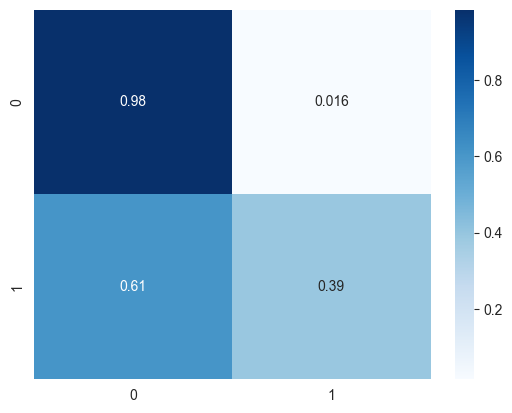

In [28]:
reports_dir = proj_path/'reports'
reports_dir.mkdir(exist_ok=True)
fig_dir = reports_dir/'figures'
fig_dir.mkdir(exist_ok=True)

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.savefig(fig_dir/'cm.png')

In [29]:
out_feat_names = model[:-1].get_feature_names_out(feat_cols)
out_feat_names

array(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], dtype=object)

In [30]:
from joblib import dump
models_dir = proj_path/'models'
models_dir.mkdir(exist_ok=True)
dump(model, models_dir/'clf-model.joblib');